In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Countries

## Data

In [2]:
owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', parse_dates=['date'])
owid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [3]:
owid.drop(columns=owid.columns[8:43], inplace=True)
owid.drop(columns=owid.columns[11:], inplace=True)
owid.drop(columns=owid.columns[5:7], inplace=True)

owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104341 entries, 0 to 104340
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   iso_code            104341 non-null  object        
 1   continent           99483 non-null   object        
 2   location            104341 non-null  object        
 3   date                104341 non-null  datetime64[ns]
 4   total_cases         100202 non-null  float64       
 5   total_deaths        89923 non-null   float64       
 6   stringency_index    87304 non-null   float64       
 7   population          103644 non-null  float64       
 8   population_density  96861 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 7.2+ MB


In [4]:
owid.head()

,iso_code,continent,location,date,total_cases,total_deaths,stringency_index,population,population_density
0,AFG,Asia,Afghanistan,2020-02-24,1.0,NaN,8.33,38928341.0,54.422
1,AFG,Asia,Afghanistan,2020-02-25,1.0,NaN,8.33,38928341.0,54.422
2,AFG,Asia,Afghanistan,2020-02-26,1.0,NaN,8.33,38928341.0,54.422
3,AFG,Asia,Afghanistan,2020-02-27,1.0,NaN,8.33,38928341.0,54.422
4,AFG,Asia,Afghanistan,2020-02-28,1.0,NaN,8.33,38928341.0,54.422


The correct way of taking the actual value of cumulative cases/deaths is to compute the latest date (for each country) first;
```
last_date = owid[['iso_code', 'date']].groupby('iso_code').max()
```
but **supposing there aren't** that many **errors**, the fact that they are cumulative functions simplifies the operation.

In [5]:
df = owid[['iso_code', 'stringency_index', 'population', 'population_density']].groupby('iso_code').mean()
# monotonic increasing functions
df['cases'] = owid[['iso_code', 'total_cases']].groupby('iso_code').max()
df['deaths'] = owid[['iso_code', 'total_deaths']].groupby('iso_code').max()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, ABW to ZWE
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stringency_index    182 non-null    float64
 1   population          229 non-null    float64
 2   population_density  207 non-null    float64
 3   cases               201 non-null    float64
 4   deaths              194 non-null    float64
dtypes: float64(5)
memory usage: 10.8+ KB


In [6]:
df['prop_case'] = df['cases'] / df['population']
df['prop_death'] = df['deaths'] / df['population']

## Visualization

In [7]:
# countries (and position in plot)

# cases
col_drop = ['population', 'population_density', 'deaths', 'prop_case', 'prop_death']

min_case = df.sort_values(by='cases').drop(columns=col_drop).dropna().head()
min_case['iso_code'] = min_case.index
max_case = df.sort_values(by='cases').drop(columns=col_drop).dropna().tail()
max_case['iso_code'] = max_case.index

# deaths
col_drop = ['population', 'population_density', 'cases', 'prop_case', 'prop_death']

min_death = df.sort_values(by='deaths').drop(columns=col_drop).dropna().head()
min_death['iso_code'] = min_death.index
max_death = df.sort_values(by='deaths').drop(columns=col_drop).dropna().tail()
max_death['iso_code'] = max_death.index

# proportions
col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_death']
max_propc = df.sort_values(by='prop_case').drop(columns=col_drop).dropna().tail()
max_propc['iso_code'] = max_propc.index

col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_case']
max_propd = df.sort_values(by='prop_death').drop(columns=col_drop).dropna().tail()
max_propd['iso_code'] = max_propd.index

# policy index
col_drop.pop()
max_ind = df.sort_values(by='stringency_index').drop(columns=col_drop).dropna().tail()
max_ind['iso_code'] = max_ind.index

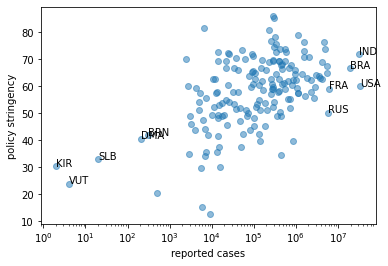

In [8]:
fig, ax = plt.subplots()
ax.semilogx(df['cases'], df['stringency_index'], 'o', alpha=0.5)
ax.set_xlabel('reported cases')
ax.set_ylabel('policy stringency')
# text annotations
for idx in min_case.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_case.values:
  ax.text(idx[1], idx[0], idx[2])
fig.show()

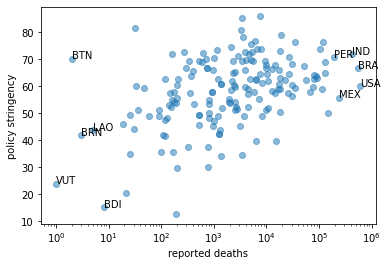

In [9]:
fig, ax = plt.subplots()
ax.semilogx(df['deaths'], df['stringency_index'], 'o', alpha=0.5)
ax.set_xlabel('reported deaths')
ax.set_ylabel('policy stringency')
# text annotations
for idx in min_death.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_death.values:
  ax.text(idx[1], idx[0], idx[2])
fig.show()

Problem with the different sizes in populations of the countries and with **underreporting** the number of cases and deaths in certain countries.


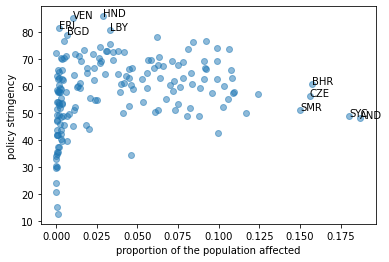

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['prop_case'], df['stringency_index'], alpha=0.5)
ax.set_xlabel('proportion of the population affected')
ax.set_ylabel('policy stringency')
# text annotations
for idx in max_propc.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[1], idx[0], idx[3])
fig.show()

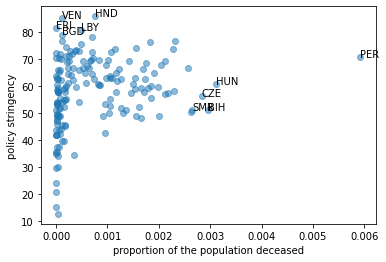

In [11]:
fig, ax = plt.subplots()
ax.scatter(df['prop_death'], df['stringency_index'], alpha=0.5)
ax.set_xlabel('proportion of the population deceased')
ax.set_ylabel('policy stringency')
# text annotations
for idx in max_propd.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[2], idx[0], idx[3])
fig.show()

Consider **outliers**, possibly non representative values for countries on the bottom left of the plots.

## Selection

List of countries and corresponding ISO codes.

In [12]:
cc_dict = {k:v for k, v in zip(owid['iso_code'].unique(), owid['location'].unique())}
for iso in cc_dict:
  print(f'{iso:9} => {cc_dict[iso]}')

AFG       => Afghanistan
OWID_AFR  => Africa
ALB       => Albania
DZA       => Algeria
AND       => Andorra
AGO       => Angola
AIA       => Anguilla
ATG       => Antigua and Barbuda
ARG       => Argentina
ARM       => Armenia
ABW       => Aruba
OWID_ASI  => Asia
AUS       => Australia
AUT       => Austria
AZE       => Azerbaijan
BHS       => Bahamas
BHR       => Bahrain
BGD       => Bangladesh
BRB       => Barbados
BLR       => Belarus
BEL       => Belgium
BLZ       => Belize
BEN       => Benin
BMU       => Bermuda
BTN       => Bhutan
BOL       => Bolivia
BES       => Bonaire Sint Eustatius and Saba
BIH       => Bosnia and Herzegovina
BWA       => Botswana
BRA       => Brazil
VGB       => British Virgin Islands
BRN       => Brunei
BGR       => Bulgaria
BFA       => Burkina Faso
BDI       => Burundi
KHM       => Cambodia
CMR       => Cameroon
CAN       => Canada
CPV       => Cape Verde
CYM       => Cayman Islands
CAF       => Central African Republic
TCD       => Chad
CHL       => Chil

Locate a specific country (by ISO code).

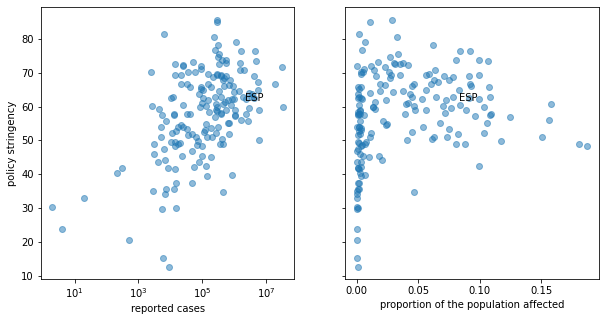

In [13]:
cc = 'ESP' # ISO code for the country

# plot
text_prop = {'va': 'center', 'ha': 'center'}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].semilogx(df['cases'], df['stringency_index'], 'o', alpha=0.5)
axs[0].set_xlabel('reported cases')
axs[0].set_ylabel('policy stringency')
axs[0].text(df.loc[cc, 'cases'], df.loc[cc, 'stringency_index'], cc, text_prop)
axs[1].scatter(df['prop_case'], df['stringency_index'], alpha=0.5)
axs[1].set_xlabel('proportion of the population affected')
axs[1].text(df.loc[cc, 'prop_case'], df.loc[cc, 'stringency_index'], cc, text_prop)
fig.show()

Interesting final objectives for analysis. Potential targets.

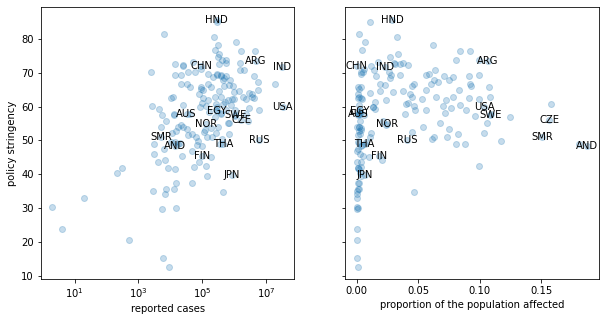

In [14]:
ccs = [ # country codes
       'AND', 'ARG', 'AUS', 'CHN', 'CZE', 'EGY', 'FIN', 'HND', 
       'IND', 'JPN', 'NOR', 'RUS', 'SMR', 'SWE', 'THA', 'USA'
]

# plot
text_prop = {'va': 'center', 'ha': 'center'}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].semilogx(df['cases'], df['stringency_index'], 'o', alpha=0.25)
axs[0].set_xlabel('reported cases')
axs[0].set_ylabel('policy stringency')
axs[1].scatter(df['prop_case'], df['stringency_index'], alpha=0.25)
axs[1].set_xlabel('proportion of the population affected')
for cc in ccs:
  axs[0].text(df.loc[cc, 'cases'], df.loc[cc, 'stringency_index'], cc, text_prop)
  axs[1].text(df.loc[cc, 'prop_case'], df.loc[cc, 'stringency_index'], cc, text_prop)
fig.show()

Issue with big (geographically speaking) countries. Explore ratio with respect to cities. May be more representative. It may not be a relevant issue however.

# Policies

## Data

In [15]:
oxcgrt = pd.read_csv(
    'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv',
    dtype={'RegionName': str, 'RegionCode': str} # avoid error warning
)
oxcgrt.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True) # region information

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']    # only national status

oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106020 entries, 0 to 177839
Data columns (total 49 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            106020 non-null  object        
 1   CountryCode                            106020 non-null  object        
 2   Jurisdiction                           106020 non-null  object        
 3   Date                                   106020 non-null  datetime64[ns]
 4   C1_School closing                      103605 non-null  float64       
 5   C1_Flag                                80829 non-null   float64       
 6   C2_Workplace closing                   103559 non-null  float64       
 7   C2_Flag                                75263 non-null   float64       
 8   C3_Cancel public events                103603 non-null  float64       
 9   C3_Flag                                81125 non

Range of time available.

In [17]:
print(oxcgrt['Date'].min(), '<--->', oxcgrt['Date'].max())
print(oxcgrt['Date'].max() - oxcgrt['Date'].min())

2020-01-01 00:00:00 <---> 2021-07-23 00:00:00
569 days 00:00:00


The chosen types of policy have flags that contain geographic scope. The possible values are:
- 0: targeted
- 1: general

In [18]:
flag_idx = oxcgrt.columns[1:18:2]

In [19]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean()

,C1_Flag,C2_Flag,C3_Flag,C4_Flag,C5_Flag,C6_Flag,C7_Flag
CountryCode,,,,,,,
AND,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ARG,0.574338,0.114754,0.925403,0.592213,0.320248,0.159836,0.449692
AUS,0.084475,0.097107,0.234216,0.164969,0.000000,0.190476,0.120902
CHN,0.227357,0.090573,0.038532,0.012844,0.260394,0.100971,0.125704
CZE,0.957916,0.804829,1.000000,0.946000,0.081395,1.000000,0.488449
EGY,0.966597,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FIN,0.570552,0.569697,0.581818,0.416476,NaN,0.870861,0.756757
HND,1.000000,1.000000,1.000000,1.000000,1.000000,0.936864,1.000000
IND,0.371769,0.093496,0.499006,0.083845,0.409326,0.188192,0.284738


In [20]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean().mean(axis=1)

CountryCode
AND    1.000000
ARG    0.448069
AUS    0.127449
CHN    0.122339
CZE    0.754084
EGY    0.995228
FIN    0.627693
HND    0.990981
IND    0.275767
JPN    0.644938
NOR    0.907653
RUS    0.145263
SMR    1.000000
SWE    0.930392
THA    0.646559
USA    0.127281
dtype: float64

It would be ideal to feed the model countries that apply the same policies to all its territory (becauses the analysis is at national level).

In [21]:
avg_scope = oxcgrt[flag_idx].groupby('CountryCode').mean().mean(axis=1)
idx_sorted = np.argsort(avg_scope.values)
sorted = avg_scope.iloc[idx_sorted[:-1]][::-1]
sorted.drop(labels=['VIR', 'GUM', 'RKS', 'PRI'], axis=0, inplace=True)
sorted

CountryCode
NIC    1.000000
MCO    1.000000
HKG    1.000000
SWZ    1.000000
LIE    1.000000
         ...   
USA    0.127281
CAN    0.125887
CHN    0.122339
IDN    0.106877
BRA    0.000000
Length: 181, dtype: float64

But the countries also need to be big enough so that the analysis is statistically significant.

In [22]:
pop_min = 10**7
populated = owid.groupby('iso_code').mean()['population'] > pop_min
populated = populated[sorted.index]
selected = sorted[populated].head(25)
selected

CountryCode
MLI    1.000000
NLD    0.995927
EGY    0.995228
DOM    0.993167
ZAF    0.990986
JOR    0.987842
POL    0.985400
MWI    0.985145
ZWE    0.984768
CMR    0.962168
SSD    0.958953
IRQ    0.956810
BEL    0.955273
ZMB    0.936817
SWE    0.930392
TUN    0.906875
HTI    0.904762
MOZ    0.893663
NGA    0.892386
KEN    0.889378
BFA    0.879325
PRT    0.876463
TZA    0.871377
MAR    0.862140
NER    0.861300
dtype: float64

In [23]:
{k:cc_dict[k] for k in selected.index}

{'BEL': 'Belgium',
 'BFA': 'Burkina Faso',
 'CMR': 'Cameroon',
 'DOM': 'Dominican Republic',
 'EGY': 'Egypt',
 'HTI': 'Haiti',
 'IRQ': 'Iraq',
 'JOR': 'Jordan',
 'KEN': 'Kenya',
 'MAR': 'Morocco',
 'MLI': 'Mali',
 'MOZ': 'Mozambique',
 'MWI': 'Malawi',
 'NER': 'Niger',
 'NGA': 'Nigeria',
 'NLD': 'Netherlands',
 'POL': 'Poland',
 'PRT': 'Portugal',
 'SSD': 'South Sudan',
 'SWE': 'Sweden',
 'TUN': 'Tunisia',
 'TZA': 'Tanzania',
 'ZAF': 'South Africa',
 'ZMB': 'Zambia',
 'ZWE': 'Zimbabwe'}

### Pivoting data

In [24]:
stringent = oxcgrt.pivot(index='Date', columns='CountryCode', values='StringencyIndex')
stringent.head()

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BMU,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,COD,COG,COL,COM,CPV,...,SGP,SLB,SLE,SLV,SMR,SOM,SRB,SSD,SUR,SVK,SVN,SWE,SWZ,SYC,SYR,TCD,TGO,THA,TJK,TKM,TLS,TON,TTO,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,5.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
cases = oxcgrt.pivot(index='Date', columns='CountryCode', values='ConfirmedCases')
cases[50:55] # first values are NA

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BMU,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,COD,COG,COL,COM,CPV,...,SGP,SLB,SLE,SLV,SMR,SOM,SRB,SSD,SUR,SVK,SVN,SWE,SWZ,SYC,SYR,TCD,TGO,THA,TJK,TKM,TLS,TON,TTO,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-20,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,74999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-21,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,75472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,76922.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,2.0,76938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,1.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0,77152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0


In [26]:
idc = oxcgrt.columns[range(4, 19, 2)]

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[7])

idc

Index(['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls'],
      dtype='object')

## Visualization

Time relationship between the number of cases and the moment policies were implemented.

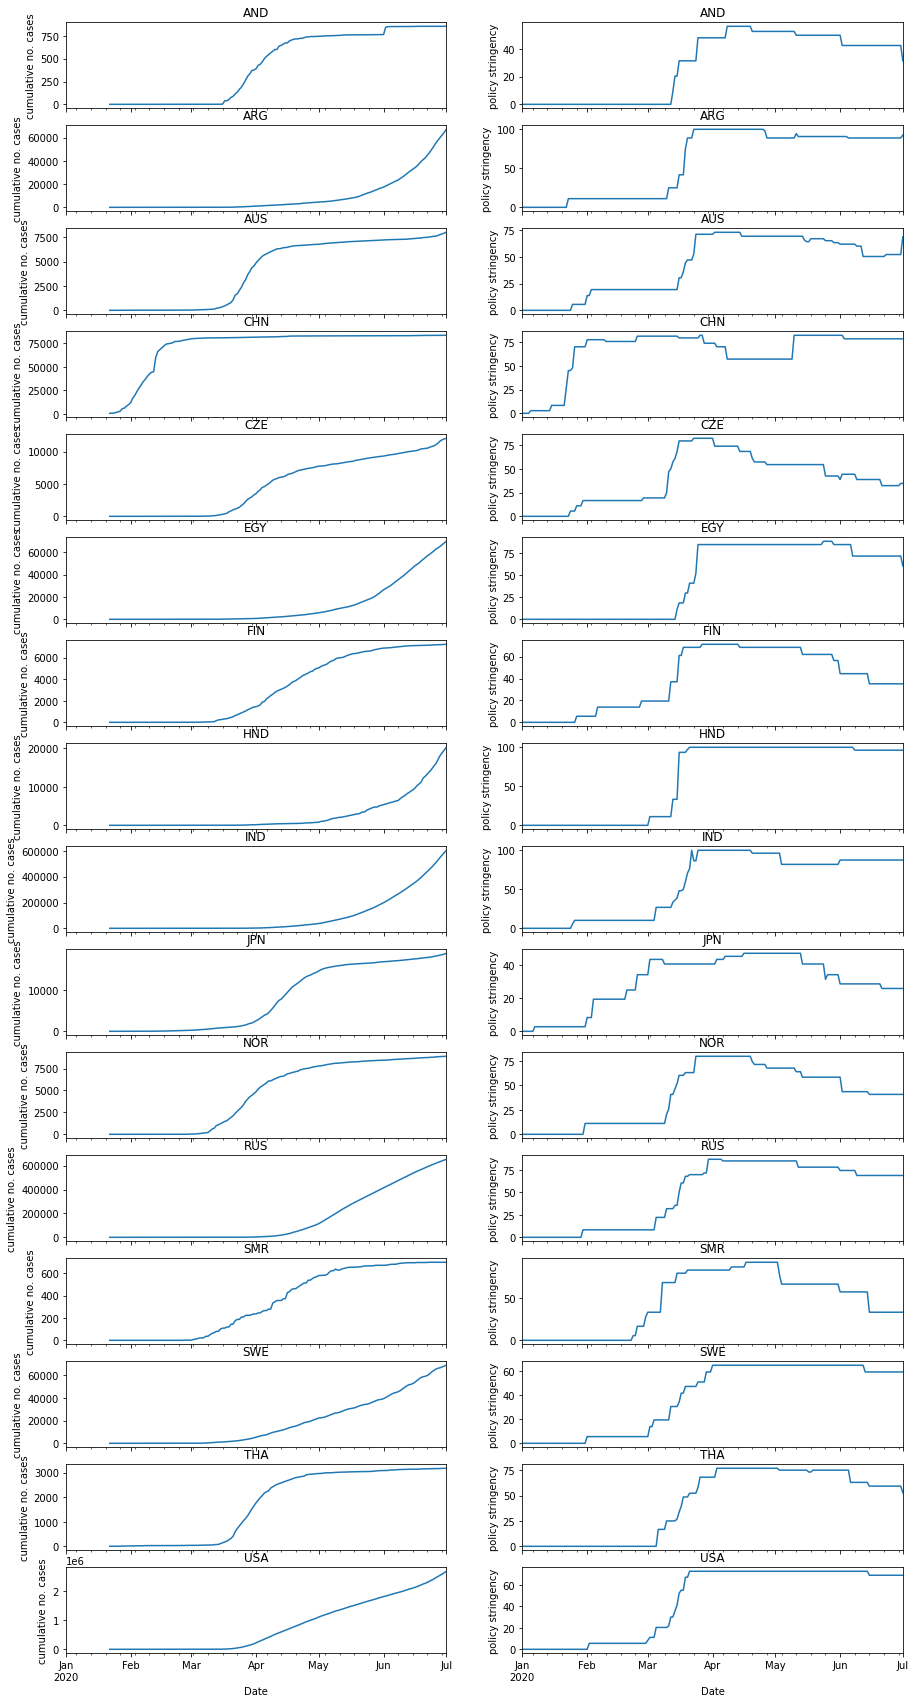

In [27]:
nrows = len(ccs)
ncols = 2
t0, t1 = '2020-01-01', '2020-07-01'

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 30))
for i in range(nrows):
  cases.loc[t0:t1, ccs[i]].plot(ax=axs[i, 0])
  stringent.loc[t0:t1, ccs[i]].plot(ax=axs[i, 1])
  axs[i, 0].set_title(ccs[i])
  axs[i, 1].set_title(ccs[i])
  axs[i, 0].set_ylabel('cumulative no. cases')
  axs[i, 1].set_ylabel('policy stringency')
fig.show()

Implementation time of different (containment) policies.

In [28]:
for i in idc:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls


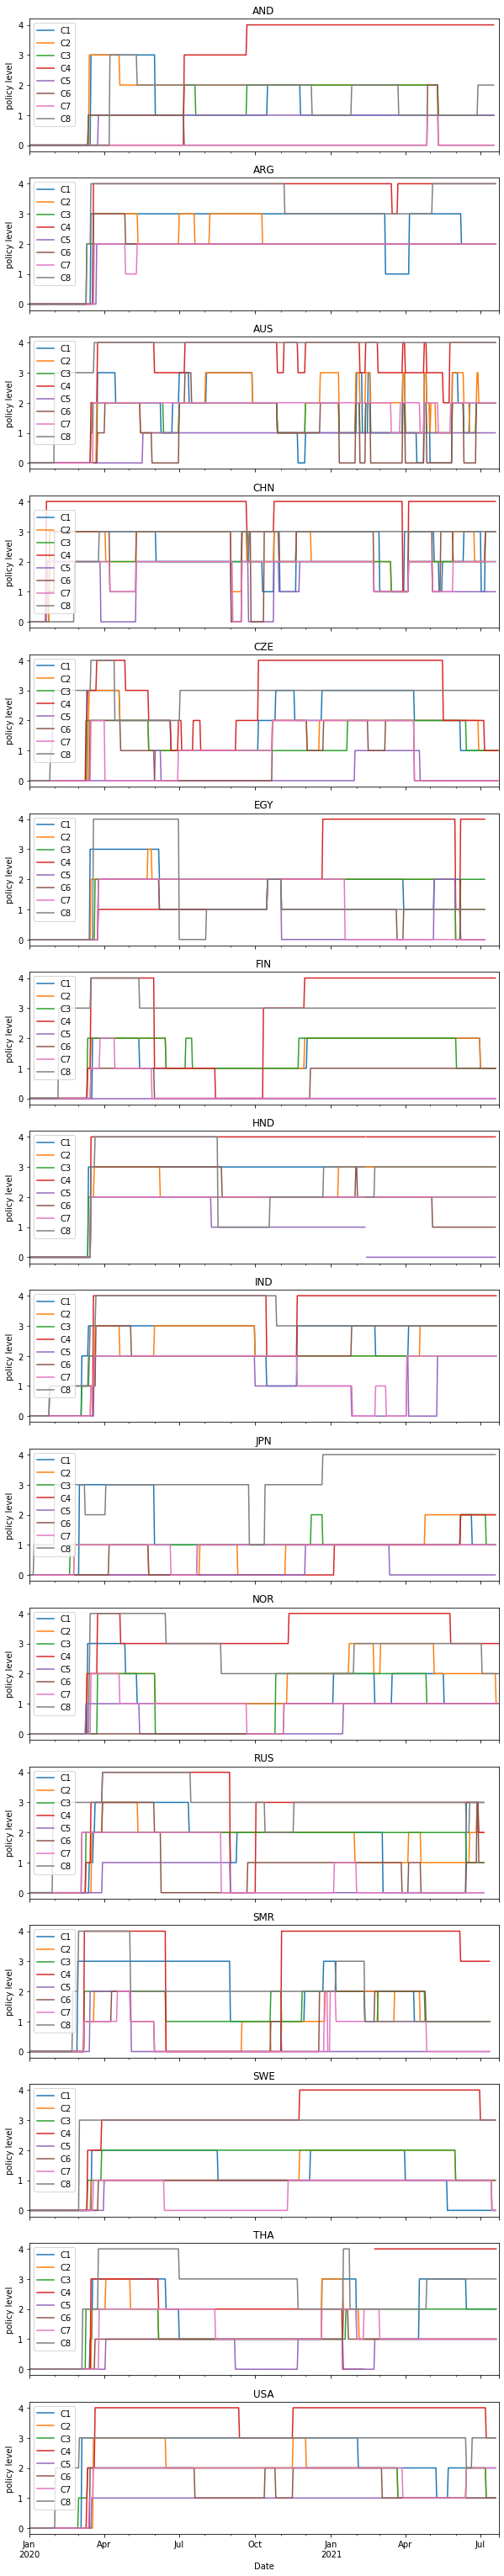

In [29]:
fig, axs = plt.subplots(nrows=nrows, sharex=True, figsize=(10, 55))
for i in range(nrows):
  # policy indicators
  C1[ccs[i]].plot(ax=axs[i])
  C2[ccs[i]].plot(ax=axs[i])
  C3[ccs[i]].plot(ax=axs[i])
  C4[ccs[i]].plot(ax=axs[i])
  C5[ccs[i]].plot(ax=axs[i])
  C6[ccs[i]].plot(ax=axs[i])
  C7[ccs[i]].plot(ax=axs[i])
  C8[ccs[i]].plot(ax=axs[i])
  # labels
  axs[i].set_title(ccs[i])
  axs[i].set_ylabel('policy level')
  axs[i].legend([s.split('_')[0] for s in idc])
fig.show()